In [1]:
import numpy as np
import pandas as pd
import math as math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import minimize, Parameters, report_fit

# Creep Model 6: Modified Time Hardening
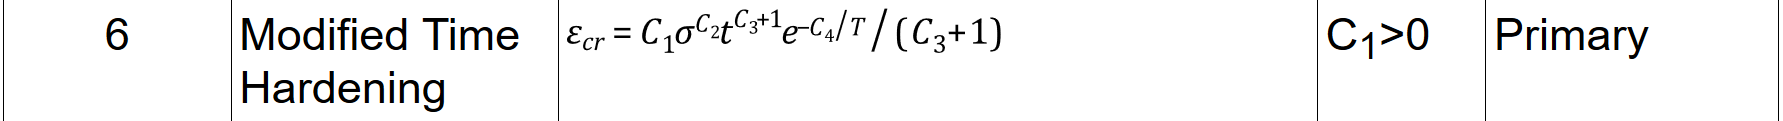

In [2]:
# Creep equantion
def creep_strain_6(stress, time, temp, C1, C2, C3, C4):
    
    model = C1 * stress**C2 * time**(C3 + 1) * np.exp(-C4 / temp) / (C3 + 1)
    
    return model

In [3]:
# Creep equantion dataset
def creep_strain_6_dataset(fit_params, exp):
    C1 = fit_params['C1'].value
    C2 = fit_params['C2'].value
    C3 = fit_params['C3'].value
    C4 = fit_params['C4'].value
    
    #data = exp[exp['data_set'] == 'exp%z' %i]
    
    time = exp['time']
    stress = exp['seqv']
    temp = exp['temp']    
    
    model = creep_strain_6(stress, time, temp, C1, C2, C3, C4)
    
    return model

In [4]:
# Equantion to calculate residual
def objective(fit_params, data, exp):
    # make residual per data set
    
    model = creep_strain_6_dataset(fit_params, exp)
    
    return data - model

In [5]:
# Simulation of experemental data

# File to be saved
output = r'e:\Mat\sim_exp_T900_S200.csv'

# Input Data
temp_C = 900 # Temperature [deg C]
stress = 200 #[MPa]
max_time_h = 500 # maximum timepoint [h]

# Quantity of experemental points 
n = 10

# Coefficients
C1 = 3.8852750e-15
C2 = 2.270096
C3 = -0.681
C4 = 23478.7482736

# Sim test data
creq = [] # Strain [m/m]
x = np.linspace( 0, 1, n)
time = (max_time_h*3600) * x**2 # Time [sec] (time step is changing with power law)
seqv = stress * 1e6 # Stress [Pa]
temp = temp_C + 273.15 # Temperature [K]

seqv = np.repeat(seqv, n)
temp = np.repeat(temp, n)

# Strain calculation
creq = creep_strain_6(seqv, time, temp, C1, C2, C3, C4) 
deviation = np.random.randint(-100, 101, size=len(time)) / 100 * 0.1
creq = creq + (creq * deviation)

# Data Frame with simulated experemental data 
d = {'time': time, 'creq': creq, 'seqv': seqv, 'temp': temp, }
sim_exp_data = pd.DataFrame(data = d)
sim_exp_data

#sns.scatterplot(time, sim_exp_data['creq'])

sim_exp_data.to_csv(output, index=False)

In [6]:
#num of imported files
numif = 3

# Read experemental data
exp1 = pd.read_csv(r'e:\Mat\sim_exp_T800_S200.csv')
exp2 = pd.read_csv(r'e:\Mat\sim_exp_T800_S300.csv')
exp3 = pd.read_csv(r'e:\Mat\sim_exp_T900_S200.csv')

# Create summary dataset
exp1['data_set'] = 'exp1'
exp2['data_set'] = 'exp2'
exp3['data_set'] = 'exp3'

exp = exp1.append(exp2,ignore_index=True) \
          .append(exp3,ignore_index=True)

data = exp['creq']

stress = exp['seqv']
time = exp['time']
temp = exp['temp']

#print imported files
#print(exp1.tail())
#print(exp2.tail())
#print(exp3.tail())

#plot imported files
#plt.plot(exp1['time'], exp1['creq'], 'o')
#plt.plot(exp2['time'], exp2['creq'], 'o')
#plt.plot(exp3['time'], exp3['creq'], 'o')


In [7]:
# Fit parametrs
fit_params = Parameters()
# example: fit_params.add('C1', value=0.5, min=1e-25,  max=200, vary=True)
fit_params.add('C1', value=0.5, min=1e-25, vary=True)
fit_params.add('C2', value=0.4, vary=True)
fit_params.add('C3', value=0.3, vary=True)
fit_params.add('C4', value=0.3, vary=True)

In [8]:
result = minimize(objective, fit_params, args=(data, exp))
result.params
#result.__dict__

name,value,initial value,min,max,vary
C1,2.1297e-09,0.5,1.0000e-25,inf,True
C2,1.43519026,0.4,-inf,inf,True
C3,-0.69582841,0.3,-inf,inf,True
C4,20103.1183,0.3,-inf,inf,True


In [9]:
C1 = result.params['C1'].value
C2 = result.params['C2'].value
C3 = result.params['C3'].value
C4 = result.params['C4'].value

In [10]:
exp['fit_creq'] = creep_strain_6(stress, time, temp, C1, C2, C3, C4)

In [11]:
exp.tail(3)

,time,creq,seqv,temp,data_set,fit_creq
67,1.088889e+06,0.014000,200000000.0,1173.15,exp3,0.014222
68,1.422222e+06,0.015435,200000000.0,1173.15,exp3,0.015425
69,1.800000e+06,0.015972,200000000.0,1173.15,exp3,0.016571


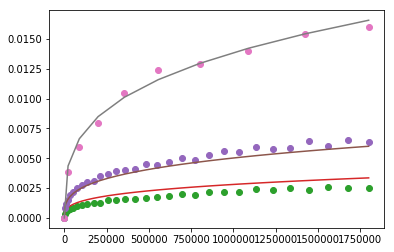

In [12]:
# Plot results
plt.figure()
for iy in range(numif+1):
    filtr = 'exp%i' %iy
    data_filt = exp[exp['data_set'] == filtr]
    time_filt = data_filt['time']
    creq_filt = data_filt['creq']
    fit_creq_filt = data_filt['fit_creq']

    plt.plot(time_filt, creq_filt, 'o', time_filt, fit_creq_filt, '-')
    
plt.show()

In [13]:
assert(C1 > 0)
assert(len(exp) == (len(exp1) + len(exp2) + len(exp3)))